# GW190521 Localisation and Prospective AGN
In this notebook, I extract the LIGO sky localisation data from the GWTC-2.1 fits file for the GW event GW190521. I use `IGWN-GWTC2p1-v2-GW190521_030229_PEDataRelease_cosmo_reweight_C01:IMRPhenomXPHM.fits` file for this. From this we obtain the declination and right ascension angles following the steps in the LIGO Parameter Estimation Data Release tutorial: https://dcc.ligo.org/public/0169/P2000223/007/PEDataReleaseExample.html  
We use the DR16 release of the SDSS catalog to obtain the data for AGNs. Specifically we use the Value Added Catalog https://iopscience.iop.org/article/10.3847/1538-4365/ac9ead/pdf that uses spectroscopy methods to calculate the masses of the SMBH that is observed using the SDSS.  
We uses the already written objects to calculate the AGN disk properties using the pAGN module and the previously defined EM counterpart formulas. These are stored in a separate EM_CP_class.py file as AGN_model and EM_model classes.
As we have ~4000 SMBH that lie within the 90% credible region of angular and distance localisation of the GW signal, we calculate the AGN disk properties and the EM counterpart properties in a pickle file which we can use later to analyse.

In [1]:
"""
Here we import all the required modules that we are using. The important modules to note are the
AGN_model and the EM_model class that is imported from EM_CP_class module written in a separate file.
Other than that we use the read_sky_map function from ligo to read the GW fits file and the astropy fits function to
read the AGN fits file, simply for convenience.
"""

from EM_CP_class import AGN_model, EM_model
import pagn.constants as ct
import pickle

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal
from ligo.skymap.io import read_sky_map
from astropy.io import fits

from ligo.skymap.postprocess import find_greedy_credible_levels
import healpy as hp
import numpy as np
import matplotlib.pyplot as plt

from ligo.skymap.io import fits as ligofits
from astropy.cosmology import Planck18
import ligo.skymap.plot
from ligo.skymap.distance import marginal_pdf, marginal_ppf

### Below we load the ligo skymap data
The skymap is basically the probability density at each pixel of sky that is being mapped. We can obtain the values of the right ascension and the declination of the centre of each pixel using the healpy.pix2ang function.  

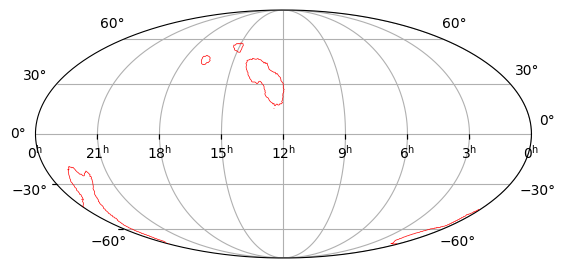

1282.4326628920387 6231.284066313325


In [2]:
fits_file = "/Users/jhuma/Lahar_work/multimessenger_project/data_store/GW_skymap/IGWN-GWTC2p1-v2-GW190521_030229_PEDataRelease_cosmo_reweight_C01:IMRPhenomXPHM.fits"
contour_levels = [90]

skymap, metadata = read_sky_map(fits_file, nest=None, distances=True)

# find_greedy_credible_levels takes the probability density at each pixel, sorts it in decreasing order, calculates the cumulative
# probability density, and returns this value in the original arrangement of the input array
cls = 100 * find_greedy_credible_levels(skymap[0])

ax = plt.axes(projection=('astro hours mollweide'))

cs = ax.contour_hpx((cls, 'ICRS'), nested=metadata['nest'], colors='red', linewidths=0.5, levels=contour_levels)
ax.grid(True)
plt.show()

# marginal_ppf will return the values of the cumulative values of the xaxis where the cumulative probability till that value is the 
# value asked for, here 0.05 and 0.95. We can see that the between these two values there is a 90% probability to find the event.
d_low, d_high = marginal_ppf([0.05, 0.95], skymap[0], skymap[1], skymap[2], skymap[3])

print(d_low, d_high)

# nside returns the number of pixels in each side of the sky region. hpix sides are normally 12*nside**2
# pix90 are all the pixels inside the red regions of the plot below.
nside_190521 = hp.get_nside(skymap)
pix90_190521 = np.where(cls <= 90)[0]

### SDSS DR16 VAC Catalog Load
Below we load the AGN catalog from the fits file. The file contains the right ascension and the declination angles for each AGN that SDSS has detected. The use of the VAC is that it also stores the mass for each AGN calculated using spectroscopic methods as mentioned in its release paper.  
The idea here is to find take the angles of each AGN, find its pixel location on a healpix graph and check whether it lies in the 90% credible region of the GW event which we have found above `pix90_190521`.  
Secondly, this catalog does not straight up store the Luminosity Distance, but stores the redshift data of the AGN. We have to use a cosmological model (we use the LambdaCDM model 2018 Planck Collaboration results using the Planck18 module from astropy).  


In [3]:
fits_file_open = fits.open("/Users/jhuma/Lahar_work/multimessenger_project/data_store/AGN_catalog/dr16q_prop_May01_2024.fits")
data_prop = fits_file_open[1].data
fits_file_open.close()

In [4]:
## Some of the AGNs have z = -999, which is basically because they were not observed correctly in the data. We first
## exclude those AGNs from our database.

mask_z = data_prop['Z_DR16Q'] < -1
data_prop = data_prop[~mask_z]

## We calculate the pixel index for each AGN using its angles and check whether they lie in the 90% credible region.
pix_val_AGN = hp.ang2pix(512, np.radians(90 - data_prop['DEC']), np.radians(data_prop['RA']), nest=True)
L_d_val_AGN = np.asarray(Planck18.luminosity_distance(data_prop['Z_DR16Q']))

mask_pix = np.isin(pix_val_AGN, pix90_190521)
mask_L_d = (np.isfinite(L_d_val_AGN) & (L_d_val_AGN >= d_low) & (L_d_val_AGN <= d_high))
mask_BBH = data_prop['LOGMBH']>1
mask_both = mask_pix & mask_L_d & mask_BBH

## idx is the array of indices which have AGNs which lie within the allowed region of angles and distance.
idx = np.where(mask_both)[0]

## we only require mass of the AGN in the subsequent calculations so we discard the remaining data and store only this
data_prop_mass = data_prop['LOGMBH']

#print(data_prop['LOGMBH'][438660], data_prop['SDSS_NAME'][438660]) #Just a check to see if the controversially claimed J124942.3+344929 is filtered in correctly

del data_prop, mask_both, mask_BBH, mask_L_d, mask_pix, L_d_val_AGN, pix_val_AGN, mask_z, pix90_190521, nside_190521, d_low, d_high, skymap, metadata, cls

### Disk Property and EM Counterpart Properties Calculation and Storage
Calculating the AGN disk properties using the AGN_model module mentioned above. This uses the pAGN python package tp calculate the properties. I was not able to figure out what the values of Mdot_out (the gas inflow rate at the outer boundary) should be. The Tagawa et al. 2023 paper tries to reverse calculate this to be $50L_{Edd}/c^2$. They do this by trying to reproduce the AGN Luminosity ($L_{bol}$ in the SDSS data) using a radiation efficiency of 0.1 and outer boundary radius at 10pc. In our case, however, since we are checking multiple different AGNs, we use the default parameters of pAGN, which scales the parameter value to the outer boundary radius by using Eq. 27 from the Gangardt et al. 2024 paper.

In [ ]:
"""
We skip running this part of the code here, because it takes ~6 hrs to calculate the disk properties of ~4000 disks.
Moreover, there are certain differential equations where the solutions were not able to be found. 
"""

AGN_store_dict = {}
for idx_val in idx:
    AGN_props = AGN_model(msmbh = 10**data_prop_mass[idx_val], epsilon=1e-3, m=0.5, xi=1, Mdot_out=None, Rout=None, Rin=None, 
                 opacity="combined", disk_model='Thompson', seed=100)
    try:
        AGN_props.solve_AGN_disk_prop()
        AGN_store_dict[idx_val] = AGN_props
        
    except Exception as e:
        print(f"[WARNING] AGN model failed for idx={idx_val}: {e}")
        continue
    print()

## After solving the AGN disk, we store the entire class object in a pickle file
## Pickle files let us store the whole class along with all the methods intact if we ever want to call them or look into the data
with open('/Users/jhuma/Lahar_work/multimessenger_project/data_store/AGN_disk_data/AGN_mod_store.pkl', 'rb') as f:
    AGN_data = pickle.load(f)

In [ ]:
"""
After calculating the disk properties we calculate the EM counterpart properties. At the end we again save the data
in a separate pickle file.
"""

store_em_props = {}

for key in AGN_data.keys():
    em_props = EM_model(msmbh=10**data_prop_mass[key], m_rem=150, eta_j=0.5, alpha_AGN=0.1, f_acc=15, theta_0=0.3, mag_ampl=0.1,
                 elec_frac=0.3, p=2.5, AGN_model=AGN_data[key], calc_disk_prop=False, disk_prop_vars=None)
    em_props.emission_properties_retrieve()
    store_em_props[key] = em_props

with open('/Users/jhuma/Lahar_work/multimessenger_project/data_store/AGN_disk_data/GW_EM_prop_store.pkl', 'wb') as f:
    pickle.dump(store_em_props, f)